# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**План выполнения проекта**

1. **Загрузка и первичный анализ данных**:
   - Изучение структуры датасета.
   - Выявление пропусков, аномалий и неинформативных признаков.
   - Визуализация распределений ключевых переменных.


2. **Предобработка данных**:
   - Обработка пропущенных значений и выбросов.
   - Кодирование категориальных переменных.
   - Нормализация числовых признаков.


3. **Подготовка выборок**:
   - Разделение данных на обучающую, валидационную и тестовую выборки.
   - Убедиться, что данные корректно подготовлены для обучения моделей.


4. **Обучение и сравнение моделей**:
   - Использование различных моделей: DecisionTreeRegressor и LightGBM.
   - Настройка гиперпараметров для достижения оптимального баланса между качеством и скоростью работы.


5. **Оценка результатов**:
   - Сравнение моделей по метрикам качества (RMSE), времени обучения и предсказания.
   - Выбор лучшей модели на основе критериев заказчика.


6. **Формулировка выводов и рекомендаций**:
   - Рекомендации для бизнеса на основе анализа данных и результатов моделирования.

## Загрузка и Подготовка данных

In [ ]:
!pip install -q phik
!pip install -Uq scikit-learn
!pip install -q shap

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from phik import phik_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42

In [ ]:
# Загрузка данных
try:
    df = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    df = pd.read_csv('autos.csv')  # Если файл локальный

<u>**Описане данных**</u>

**Числовые признаки**:
1. **Price (целевой признак)** - Цена автомобиля в евро.  

2. **RegistrationYear** - Год регистрации автомобиля.

3. **RegistrationMonth** - Месяц регистрации автомобиля (число от 0 до 12).  

4. **Power** - Мощность двигателя в лошадиных силах (л.с.).  

5. **Kilometer** - Пробег автомобиля в километрах.  

6. **NumberOfPictures** - Количество фотографий автомобиля в объявлении.  

**Категориальные признаки**:
1. **VehicleType** - Тип автомобильного кузова.

2. **Gearbox** - Тип коробки передач.

3. **Model** - Модель автомобиля.

4. **FuelType** - Тип топлива.

5. **Brand** - Марка автомобиля.

6. **Repaired** - Была ли машина в ремонте.

7. **PostalCode** - Почтовый индекс владельца объявления.

**Временные признаки**:
1. **DateCrawled** - Дата скачивания анкеты из базы.  

2. **DateCreated** - Дата создания анкеты.  

3. **LastSeen** - Дата последней активности пользователя.  

In [ ]:
# Функция для ознакомления с таблицами
def first_check(data, dataset_name=""):
    # Печатаем название датасета
    if dataset_name:
        print(f"Анализ датасета: {dataset_name}")
    else:
        print("Анализ датасета")
    print("=" * 40 + "\n")

    # Первые и последние строки
    print("Первые 5 строк:")
    display(data.head())
    print("\nПоследние 5 строк:")
    display(data.tail())

    # Информация о данных
    print("\nИнформация о данных:")
    display(data.info())

    # Описательная статистика
    print("\nОписательная статистика:")
    display(data.describe(include='all'))

In [ ]:
first_check(df, "df")

Анализ датасета: df

Первые 5 строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Последние 5 строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dty

None


Описательная статистика:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Всего в датасете `df` 354369 строк и 16 столбцов.

Обнаружен пропуски в столбцах: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`.

- В столбце `Price` обнаружена аномалиия, цена авто - 0 евро.
- В столбце `RegistrationYear` обнаружена аномалия - 9999 и 1000 год регистрации автомобиля.
- В столбце `Power` обнаружена аномалия - 20000 и 0 л.с. автомобиля.
- В столбце `NumberOfPictures` все значения равны 0.
- В столбцах `DateCrawled`, `DateCreated`, `LastSeen` указан неверный тип данных.

### <u>Выполним предобработку данных</u>

In [ ]:
def check_data(data, bins=10, figsize=(15, 8)):
    print('Первые 5 строк:')
    display(data.head())

    print('\nПоследние 5 строк:')
    display(data.tail())

    print('\nРазмерность данных:')
    display(data.shape)

    print('\nИнформация о типах данных и пропусках:')
    display(data.info())

    print('\nОписательная статистика:')
    display(data.describe(include='all'))

    # Анализ пропусков
    print("=" * 40)
    print('\nПропуски (количество и доля):')
    total_missing = data.isnull().sum().sort_values(ascending=False)
    percent_missing = (data.isnull().sum() / data.shape[0]).sort_values(ascending=False)
    missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['total', 'percent'])

    # Проверяем, есть ли пропуски
    if missing_data['total'].sum() > 0:
        print(missing_data[missing_data['total'] > 0])  # Вывод только столбцов с пропусками
    else:
        print('Пропуски отсутствуют в данных.')

    # Проверка на дубликаты
    duplicate_rows = data.duplicated().sum()
    if duplicate_rows > 0:
        print("=" * 40)
        print(f'\nОбнаружено {duplicate_rows} дубликатов в данных.')
        print('\nДубликаты:')
        display(data[data.duplicated()])
    else:
        print("=" * 40)
        print('\nДубликаты отсутствуют в данных.')

    # Анализ количественных столбцов
    numeric_columns = data.select_dtypes(include=['number']).columns
    numeric_columns = numeric_columns[numeric_columns != 'id']  # Исключаем столбец 'id'

    # Разделение на дискретные и непрерывные
    discrete_columns = []
    continuous_columns = []
    for col in numeric_columns:
        if data[col].nunique() < 10:  # Пороговое значение для определения дискретности
            discrete_columns.append(col)
        else:
            continuous_columns.append(col)

    # Построение гистограмм для непрерывных столбцов
    if continuous_columns:  # Проверка на наличие числового столбца
        print("=" * 40)
        print('\nГрафики распределения для количественных непрерывных столбцов (гистограммы):')
        # Определяем количество строк и столбцов для подграфиков
        n_cols = 2
        n_rows = (len(continuous_columns) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()

        for i, col in enumerate(continuous_columns):
            axes[i].hist(data[col], bins=bins, color='blue')
            axes[i].grid(True)
            axes[i].set_title(f'Распределение для {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Количество')

        # Убираем пустые подграфики, если они есть
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout() # Автоматически подгоняет подграфики
        plt.show()

    # Построение столбиковых диаграмм для дискретных столбцов
    if discrete_columns:  # Проверка на наличие числового столбца
        print("=" * 40)
        print('\nГрафики распределения для количественных дискретных столбцов (столбчатые диаграммы):')
        # Определяем количество строк и столбцов для подграфиков
        n_cols = 2
        n_rows = (len(discrete_columns) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()  # Создаем одномерный массив

        for i, col in enumerate(discrete_columns):
            value_counts = data[col].value_counts().sort_index()
            axes[i].bar(value_counts.index, value_counts.values, color='green')
            axes[i].grid(True)
            axes[i].set_title(f'Распределение для {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Количество')

        # Убираем пустые подграфики, если они есть
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout() # Автоматически подгоняет подграфики
        plt.show()

    # Анализ категориальных столбцов
    categorical_columns = data.select_dtypes(exclude=['number']).columns
    if not categorical_columns.empty:
        print("=" * 40)
        print('\nАнализ категориальных столбцов:')
        for col in categorical_columns:
            print("-" * 20)
            print(f'\nСтолбец: {col}')
            value_counts = data[col].value_counts()
            n_unique = data[col].nunique()

            # Порог для определения "много/мало" уникальных значений
            threshold = 15

            if n_unique > threshold:
                # Если много уникальных значений, показываем только те, что встречаются 2+ раза
                frequent_values = value_counts[value_counts >= 2]
                if not frequent_values.empty:
                    print('Значения, встречающиеся 2 раза и больше:')
                    print(frequent_values)
                    print(f'Количество таких значений: {len(frequent_values)}')

                    # Вывод процентного соотношения двух самых частых категорий
                    total_count = len(data[col])
                    top_two = frequent_values.head(2)
                    for category, count in top_two.items():
                        percentage = (count / total_count) * 100
                        print(f'Процент категории "{category}": {percentage:.2f}%')
                else:
                    print('Нет значений, встречающихся 2 раза и больше.')
            else:
                # Если мало уникальных значений, показываем все
                print('Все уникальные значения:')
                print(value_counts)
                print(f'Количество уникальных значений: {n_unique}')

                # Вывод процентного соотношения двух самых частых категорий
                total_count = len(data[col])
                top_two = value_counts.head(2)
                for category, count in top_two.items():
                    percentage = (count / total_count) * 100
                    print(f'Процент категории "{category}": {percentage:.2f}%')

Выполним удаления столбца `NumberOfPictures` по причине неинформативности.

In [ ]:
df.drop(columns='NumberOfPictures', axis=1, inplace=True)

Первые 5 строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21



Последние 5 строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,40764,2016-03-24 12:45:21



Размерность данных:


(354369, 15)


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  PostalCode         354369 non-null  int64 
 14  LastSeen           354369 non-null  object
dtypes: int64(6), object(9)
memor

None


Описательная статистика:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,71083.000000,NaN



Пропуски (количество и доля):
             total   percent
Repaired     71154  0.200791
VehicleType  37490  0.105794
FuelType     32895  0.092827
Gearbox      19833  0.055967
Model        19705  0.055606

Обнаружено 4 дубликатов в данных.

Дубликаты:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,36391,2016-03-18 18:46:15



Графики распределения для количественных непрерывных столбцов (гистограммы):


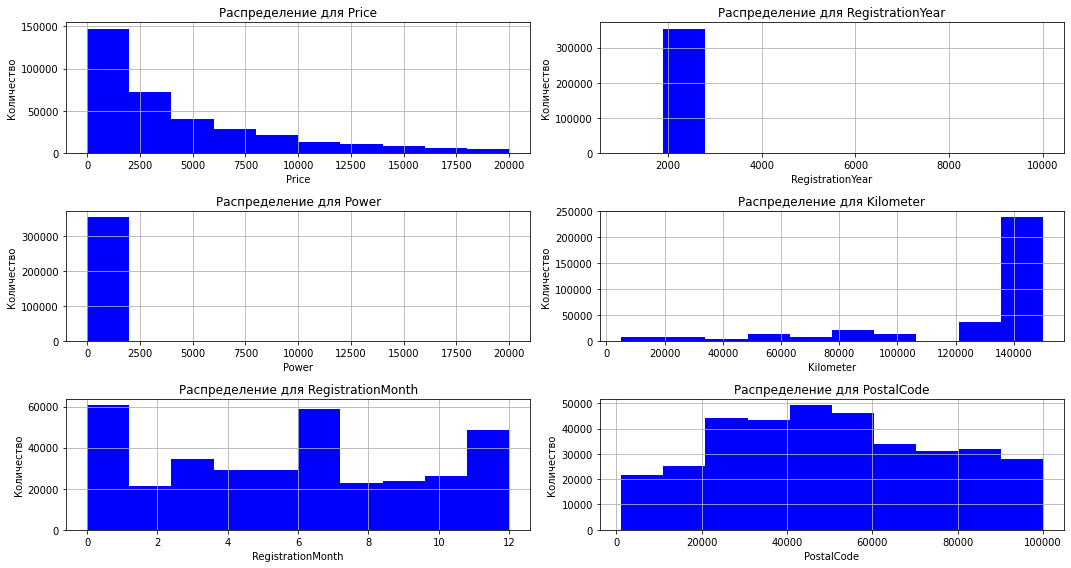


Анализ категориальных столбцов:
--------------------

Столбец: DateCrawled
Значения, встречающиеся 2 раза и больше:
2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-03-31 17:57:07    5
2016-03-11 15:36:59    5
                      ..
2016-03-17 12:47:54    2
2016-03-22 12:55:37    2
2016-03-15 10:49:02    2
2016-03-10 12:52:13    2
2016-03-28 19:51:15    2
Name: DateCrawled, Length: 76431, dtype: int64
Количество таких значений: 76431
Процент категории "2016-03-24 14:49:47": 0.00%
Процент категории "2016-03-26 22:57:31": 0.00%
--------------------

Столбец: VehicleType
Все уникальные значения:
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64
Количество уникальных значений: 8
Процент категории "sedan": 25.81%
Процент категории "small": 22.53%
--------------------

Столбец: Gearbox
Все уникальные значения:


In [ ]:
check_data(df)

- **VehicleType** - 8 уникальных значений, распределение достаточно разнообразное. Основные типы: sedan (26%) - 91457, small (23%) - 79831, wagon, bus, convertible, coupe, suv, other.

- **Gearbox** - 2 уникальных значения: manual (75%) - 268251, auto (19%) - 66285.

- **Model** - 250 уникальных значений, каждое встречается минимум 2 раза. Большое разнообразие моделей, с явным доминированием нескольких популярных (golf (8%) - 29232, other - 24421, 3er - 19761, polo - polo, corsa - 12570).

- **FuelType** - 7 уникальных значений. Основные: petrol - 216352, gasoline - 98720, lpg - 5310, cng, hybrid, other, electric.

- **Brand** - 40 уникальных значений с разной частотой. Доминируют volkswagen (22%) - 77013, opel - 39931, bmw - 36914, mercedes-benz, audi и др.

- **Repaired** - 2 уникальных значения: no (70%) - 247161 и yes - 36054.

Приведем названия признаков к змеиному регистру.

In [ ]:
def snake(s):
    return ''.join(['_' + c.lower() if c.isupper() else c for c in s]).lstrip('_')

In [ ]:
df.columns = [snake(col) for col in df.columns]

Отобразим строки помеченные как дубликаты и новые название столбцов/

In [ ]:
display(df[df.duplicated(keep=False)].sort_values('price'))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,66589,2016-03-28 08:46:21
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,36391,2016-03-18 18:46:15
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,75196,2016-04-07 09:44:54


In [ ]:
# Удалим дубликаты
df.drop_duplicates(keep='first', inplace=True)

Неявных дубликатов обнаружено не было.

Изменим тип данных в столбцах `DateCrawled`, `DateCreated`, `LastSeen`.

In [ ]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])

In [ ]:
df['date_crawled'].min()

Timestamp('2016-03-05 14:06:22')

Пропуски в столбцах `gearbox` и `model` незначительны,  заменим пропущенные значения модой.

In [ ]:
df['gearbox'].fillna(df['gearbox'].mode()[0], inplace=True)
df['model'].fillna(df['model'].mode()[0], inplace=True)

Пропуски в категориальных признаках `repaired`, `vehicle_type`, `fuel_type` заменим категориальным значением `unknown`.

In [ ]:
categorical_features = ['repaired', 'vehicle_type', 'fuel_type']
for feature in categorical_features:
    df[feature].fillna('unknown', inplace=True)

In [ ]:
# Проверка оставшихся пропусков
print(df.isnull().sum())

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
postal_code           0
last_seen             0
dtype: int64


Обработаем аномальные значения обнаруженные при первичном анализе в столбцах `price`, `registration_year` и `power`.

In [ ]:
# Устанавливаем верхнюю границу года регистрации
df['max_registration_year'] = df['date_created'].dt.year

df = df[
    (df['price'] >= 10) &
    (df['registration_year'] >= 1980) &
    (df['registration_year'] <= df['max_registration_year']) &
    (
        (df['registration_year'] < df['max_registration_year']) |
        ((df['registration_year'] == df['max_registration_year']) &
         (df['registration_month'] <= df['date_created'].dt.month))
    ) &
    (df['power'] > 0) &
    (df['power'] <= 2000)
]

# Удаляем временный столбец
df.drop(columns=['max_registration_year'], inplace=True)

Ограничиваем год регистрации автомобиля годом создания объявления. Автомобиль не может быть зарегистрирован в будущем относительно даты создания объявления.

Изучим признаки подробнее в иследовательском анализе данных

Признаки `date_crawled`, `last_seen`, `date_created`, `postal_code`, `registration_month`(год является более значимым) являются неинформативными для оценки стоимости, так как не связаны с характеристиками самого автомобиля. Данные признаки решено удалить.

In [ ]:
df = df.drop(columns=['date_crawled', 'last_seen', 'date_created', 'postal_code', 'registration_month'], axis=1)

### <u>Исследовательский анализ данных</u>

In [ ]:
# Функция для исследовательского анализа числовых признаков
def number_columns(data, column, bins=50):

    # Описательная статистика
    description = data[column].describe()
    print(f"\n=== Описательная статистика для '{column}' ===")
    print(description)

    # Проверка на выбросы с использованием IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"\nКоличество выбросов в '{column}': {len(outliers)}")

    # Построение гистограммы и boxplot
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    sns.histplot(x=data[column], kde=True, ax=ax[0], bins=bins, color='skyblue')
    ax[0].set_title(f'Гистограмма для {column}')
    ax[0].set_xlabel(column)
    ax[0].set_ylabel('Частота')

    sns.boxplot(x=data[column], ax=ax[1], color='lightgreen')
    ax[1].set_title(f'Boxplot для {column}')
    ax[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()


=== Описательная статистика для 'price' ===
count    290176.000000
mean       4867.620327
std        4604.601669
min          10.000000
25%        1350.000000
50%        3200.000000
75%        6999.000000
max       20000.000000
Name: price, dtype: float64

Количество выбросов в 'price': 13360


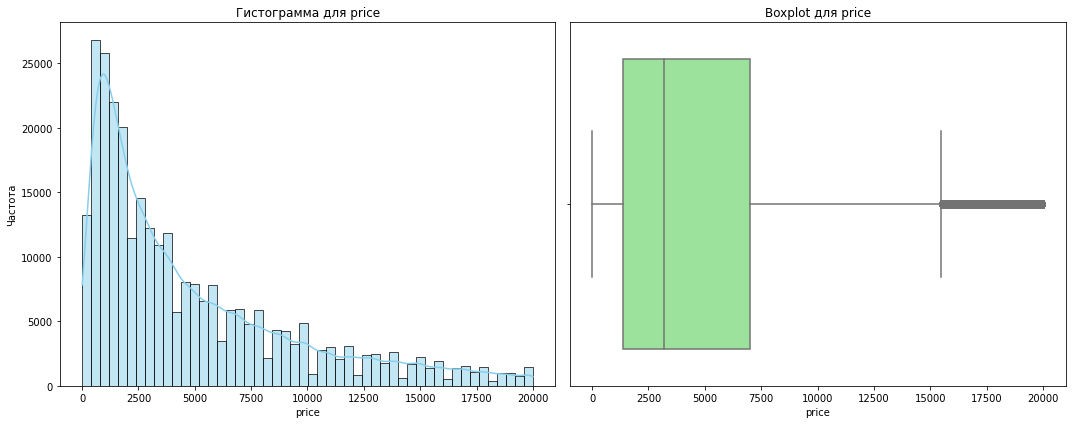

In [ ]:
number_columns(df, 'price')

In [ ]:
print(f'Процент выбросов: {14067 / df.shape[0] * 100:.2f}%')

Процент выбросов: 4.85%


После удаления части объектов в признаке `price` видим, что распределение переменной смещено вправо, большинство значений — относительно небольшие, но есть значительное количество высоких цен, которые считаются выбросами доходящие до 20000 евро. Медиана признака `price` равна 3130 евро, а средняя 4822. Процент выбросов в признаке 4.59% (решено оставить).


=== Описательная статистика для 'registration_year' ===
count    290176.000000
mean       2002.895315
std           5.763156
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

Количество выбросов в 'registration_year': 2306


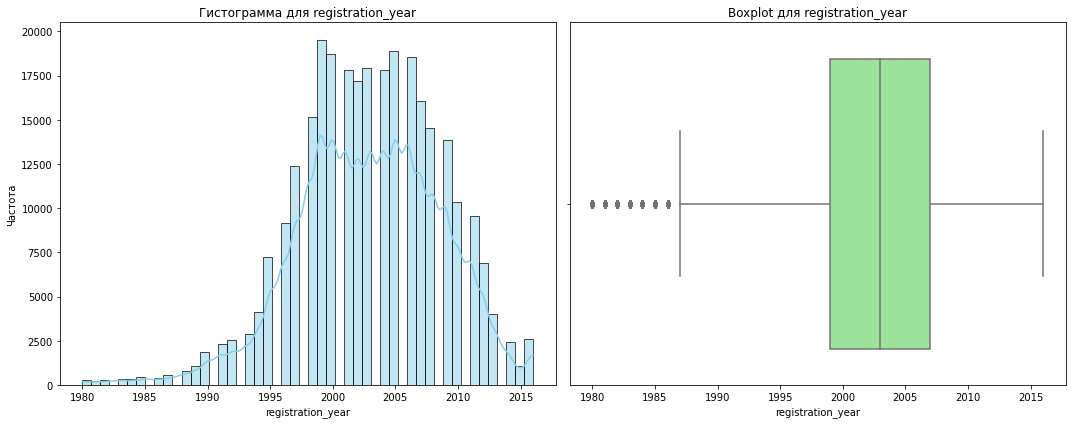

In [ ]:
number_columns(df, 'registration_year')

In [ ]:
print(f'Процент выбросов: {4094 / df.shape[0] * 100:.2f}%')

Процент выбросов: 1.41%


В признаке `registration_year` основная масса автомобилей зарегистрирована  в период с 1999 по 2008 год, пик — около 2000 года. Есть выбросы в начале графика — автомобили с годом регистрации до 1999 года, что составляет 1,34% (решено оставить) от общего размера датасета.


=== Описательная статистика для 'power' ===
count    290176.000000
mean        121.804308
std          63.124299
min           1.000000
25%          77.000000
50%         113.000000
75%         150.000000
max        2000.000000
Name: power, dtype: float64

Количество выбросов в 'power': 6310


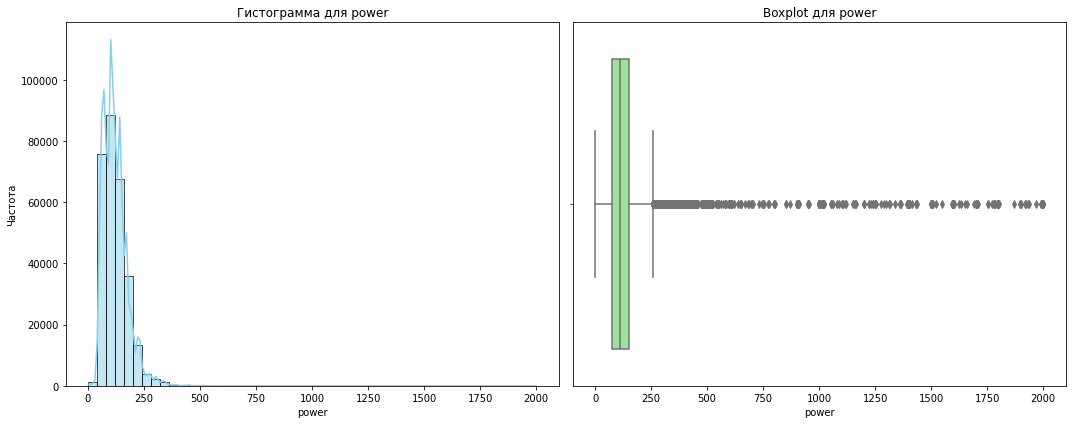

In [ ]:
number_columns(df, 'power')

In [ ]:
print(f'Процент выбросов: {6381 / df.shape[0] * 100:.2f}%')

Процент выбросов: 2.20%


На гистограмме признака `power` видно, что большинство значений мощности сосредоточено в диапазоне от 0 до 250. Медиана 110, среднее 121,1. В остальной части распределения мы видим небольшое количество выбросов около 2,1%, которое решено было не удалять.


=== Описательная статистика для 'kilometer' ===
count    290176.000000
mean     128447.821322
std       36582.284192
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Количество выбросов в 'kilometer': 43573


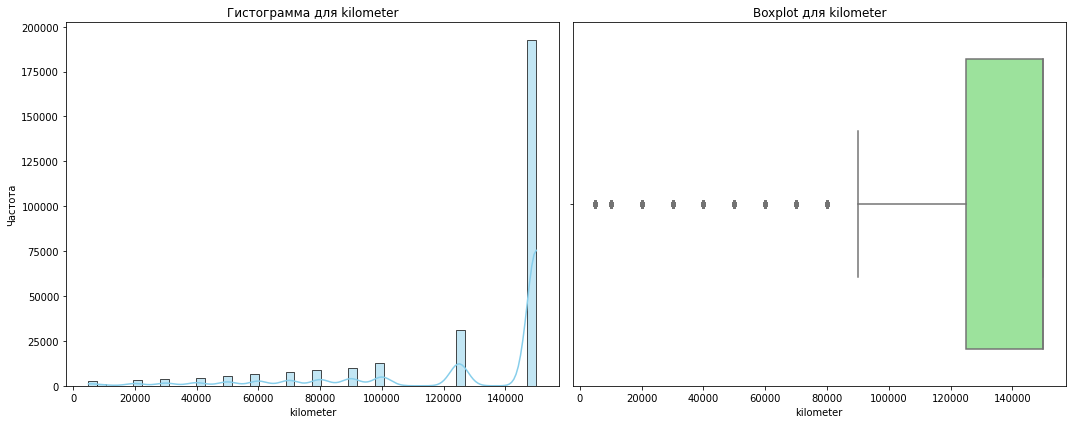

In [ ]:
number_columns(df, 'kilometer')

In [ ]:
print(f'Процент выбросов: {46019 / df.shape[0] * 100:.2f}%')

Процент выбросов: 15.86%


В признаке `kilometer` преобладают автомобили с максимальным пробегом от 140000 км. Также присутствуют выбросы в рамере 15% соответствующие  низким значениям пробега. Думаю, что это является особенностью признаки, так как на площадке могут продаваться авто из салона, поэтому выбросы решено оставить.

Анализ категориальных признаков был выполнен на этапе преобработки даннных.

### <u>Корреляционный анализ</u>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290176 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              290176 non-null  int64 
 1   vehicle_type       290176 non-null  object
 2   registration_year  290176 non-null  int64 
 3   gearbox            290176 non-null  object
 4   power              290176 non-null  int64 
 5   model              290176 non-null  object
 6   kilometer          290176 non-null  int64 
 7   fuel_type          290176 non-null  object
 8   brand              290176 non-null  object
 9   repaired           290176 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.4+ MB


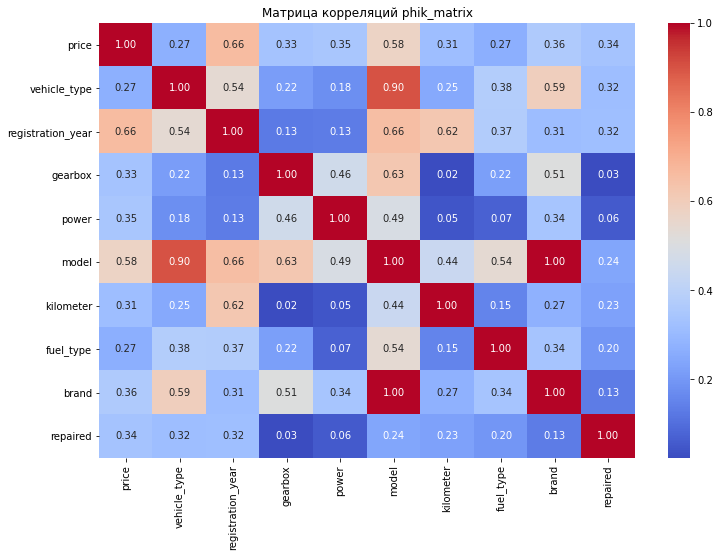

In [ ]:
# Числовые признаки для interval_cols
interval_cols = ['price', 'power', 'kilometer']

# Визуализация матрицы корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(df.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Матрица корреляций phik_matrix')
plt.show()

In [ ]:
#Удалим признак `brand` из за большой мультиколлинеарности
df = df.drop('brand', axis=1)

Анализ корреляций относительно целевого признака:

- `registration_year:` 0.68 — умеренная положительная корреляция. Чем новее год регистрации, тем выше цена.
- `model:` 0.57 — умеренная положительная корреляция. Некоторые модели имеют тенденцию к более высокой цене.
- `brand:` 0.36 — слабая положительная корреляция. Некоторые бренды имеют тенденцию быть дороже.
- `power:` 0.35 — слабая положительная корреляция. Более мощные автомобили несколько дороже.
- `gearbox:` 0.33 — слабая положительная корреляция. Автоматическая коробка передач немного связана с более высокой ценой.
- `vehicle_type:` 0.27 — слабая положительная корреляция. Определённые типы кузова немного связаны с более высокой ценой.
- `fuel_type:` 0.26 — слабая положительная корреляция. Некоторые типы топлива немного связаны с более высокой ценой.
- `repaired:` -0.33 — слабая отрицательная корреляция. Факт ремонта немного снижает цену.
- `kilometer:` -0.31 — слабая отрицательная корреляция. Чем больше пробег, тем ниже цена.

**<u>Промежуточный итог: Загрузка и Подготовка данных</u>**

**1. Загрузка и первичный анализ данных**
- **Загрузка данных**:
  Датасет успешно загружен из файла `/datasets/autos.csv`. В нем содержится **354 369 строк** и **16 столбцов**, включая числовые, категориальные и временные признаки.
  - **Целевой признак**: `price` (цена автомобиля в евро).
  - **Ключевые признаки**: `registration_year`, `model`, `brand`, `power`, `gearbox`, `vehicle_type`, `fuel_type`, `repaired`, `kilometer`.

- **Первичные наблюдения**:
  - **Пропуски**: Обнаружены в столбцах `vehicle_type` (10.6%), `gearbox` (5.6%), `model` (5.6%), `fuel_type` (9.3%), `repaired` (20.1%).
  - **Аномалии**:
    - В `price` значения **0 евро** и аномально высокие цены (до 20 000 евро).
    - В `registration_year` годы регистрации **1000** и **9999**.
    - В `power` значения **0 л.с.** и **20 000 л.с.**.
  - **Неинформативные признаки**:
    - `number_of_pictures` (все значения равны 0).

**2. Обработка пропусков и аномалий**
- **Пропуски**:
  - В категориальных признаках (`vehicle_type`, `fuel_type`, `repaired`) пропуски заполнены значением `unknown`.
  - В `gearbox` и `model` пропуски заменены **модой** (наиболее частыми значениями).

- **Аномалии**:
  - В `price` удалены объявления с ценой **< 10 евро**.
  - В `registration_year` оставлены только реалистичные года, относительно даты создания объявления.
  - В `power` удалены записи с мощностью **< 1 л.с.** или **> 2000 л.с.**.

**3. Преобразование данных**
- **Удаление неинформативных признаков**:
  - Удалены столбцы: `number_of_pictures`, `date_crawled`, `last_seen`, `postal_code`, `registration_month`, `date_created`.
- **Дубликаты**:
  - Удалено **4 дубликата** (полностью повторяющиеся строки).

**4. Исследовательский анализ данных**
- **Числовые признаки**:
  - `price`: Распределение смещено вправо, медиана — **3130 евро**.
  - `registration_year`: Большинство автомобилей зарегистрированы в **1999–2008 годах**.
  - `power`: Медианная мощность — **110 л.с.**.
  - `kilometer`: **50%** автомобилей имеют пробег **150 000 км**.

- **Категориальные признаки**:
  - `vehicle_type`: Доминируют **sedan** (26%) и **small** (23%).
  - `gearbox`: **75%** авто с механической коробкой передач, с **auto** (19%).
  - `model`: Доминирует **golf** (8%).
  - `fuel_type`: **89%** — бензиновые (`petrol`/`gasoline`).
  - `brand`: Самым популярным брендом авто является **volkswagen** (22%).
  - `repaired`: **70%** авто **не попадали в дтп**.

- **Корреляционный анализ**:
  - Сильная связь с `price`:
    - `registration_year` (0.68), `model` (0.57), `power` (0.35).
  - Слабая связь: `gearbox` (0.33), `vehicle_type` (0.27).
  - Отрицательная связь: `kilometer` (-0.31), `repaired` (-0.33).
  - Удален признак `brand` из-за мультиколлинеарности с `model`.

**5. Итоговая подготовка данных**
- **Оставшиеся признаки**:
  `price`, `registration_year`, `model`, `power`, `gearbox`, `vehicle_type`, `fuel_type`, `repaired`, `kilometer`.

## Обучение моделей

In [ ]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(217632, 8)

(217632,)

(72544, 8)

(72544,)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217632 entries, 251614 to 148863
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       217632 non-null  object
 1   registration_year  217632 non-null  int64 
 2   gearbox            217632 non-null  object
 3   power              217632 non-null  int64 
 4   model              217632 non-null  object
 5   kilometer          217632 non-null  int64 
 6   fuel_type          217632 non-null  object
 7   repaired           217632 non-null  object
dtypes: int64(3), object(5)
memory usage: 14.9+ MB


In [ ]:
# Создаём списки с названиями признаков
ohe_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type']  # Признаки без иерархии

ord_columns = ['repaired']  # Признаки с иерархией

num_columns = ['registration_year', 'power', 'kilometer']  # Числовые признаки

In [ ]:
# Пайплайн для OHE-кодирования
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [ ]:
# Пайплайн для Ordinal-кодирования
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['yes', 'unknown', 'no'],
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [ ]:
# Общая подготовка данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
# Итоговый пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

pipe_final_lgb = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', lgb.LGBMRegressor(random_state=RANDOM_STATE))
    ]
)

In [ ]:
param_grid = [
    # Словарь для модели DecisionTreeRegressor()
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(1, 21),
        'model__min_samples_split': range(2, 25),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]

param_grid_lgb = [
    {
        'model': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': range(50, 100, 200),
        'model__max_depth': range(3, 8)
    }
]

In [ ]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_iter=10,  # Количество случайных комбинаций
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'model',
                                                                                'fuel_type']),
                                                                              ('ord',
                                                                               Pipeli...
                                                                               ['registration_year',
                                                                                'power',
                                                                                'kilometer'])])),
                                             ('model',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'model': [DecisionTreeRegressor(random_state=42)],
                                         'model__max_depth': range(1, 21),
                                         'model__min_samples_split': range(2, 25),
                                         'preprocessor__num': [StandardScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
random_search_lgb = RandomizedSearchCV(
    pipe_final_lgb,
    param_grid_lgb,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_iter=10,  # Количество случайных комбинаций
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search_lgb.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnin

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'model',
                                                                                'fuel_type']),
                                                                              ('ord',
                                                                               Pipeli...
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['repaired']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['registration_year',
                                                                                'power',
                                                                                'kilometer'])])),
                                             ('model',
                                              LGBMRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'model': [LGBMRegressor(random_state=42)],
                                         'model__max_depth': range(3, 8),
                                         'model__n_estimators': range(50, 100, 200)}],
                   random_state=42, scoring='neg_root_mean_squared_error')

## Анализ моделей

**DecisionTreeRegressor.**

In [ ]:
print('Лучшие параметры DecisionTreeRegressor:', random_search.best_params_)

Лучшие параметры DecisionTreeRegressor: {'preprocessor__num': StandardScaler(), 'model__min_samples_split': 9, 'model__max_depth': 18, 'model': DecisionTreeRegressor(random_state=42)}


In [ ]:
best_tree_cv_rmse = -random_search.best_score_
print(f'Метрика RMSE, для модели DecisionTreeRegressor на кросс-валидации: {best_tree_cv_rmse:.2f}')

Метрика RMSE, для модели DecisionTreeRegressor на кросс-валидации: 1801.74


Значение метрики RMSE меньше 2500.

In [ ]:
# Время обучения и предсказания для DecisionTreeRegressor
mean_fit_time_tree = random_search.cv_results_['mean_fit_time'][random_search.best_index_]
mean_score_time_tree = random_search.cv_results_['mean_score_time'][random_search.best_index_]
print(f'Среднее время обучения, DecisionTreeRegressor: {mean_fit_time_tree:.2f} секунд')
print(f'Среднее время предсказания, DecisionTreeRegressor: {mean_score_time_tree:.2f} секунд')

Среднее время обучения, DecisionTreeRegressor: 6.67 секунд
Среднее время предсказания, DecisionTreeRegressor: 0.28 секунд


**LGBMRegressor.**

In [ ]:
print("Лучшие параметры LGBMRegressor:", random_search_lgb.best_params_)

Лучшие параметры LGBMRegressor: {'model__n_estimators': 50, 'model__max_depth': 7, 'model': LGBMRegressor(random_state=42)}


In [ ]:
best_lgbm_cv_rmse = -random_search_lgb.best_score_
print(f'Метрика RMSE, для модели LGBMRegressor на кросс-валидации: {best_lgbm_cv_rmse:.2f}')

Метрика RMSE, для модели LGBMRegressor на кросс-валидации: 1791.93


Значение метрики RMSE меньше 2500.

In [ ]:
# Время обучения и предсказания для LGBMRegressor
mean_fit_time_lgb = random_search_lgb.cv_results_['mean_fit_time'][random_search_lgb.best_index_]
mean_score_time_lgb = random_search_lgb.cv_results_['mean_score_time'][random_search_lgb.best_index_]
print(f'Среднее время обучения, LGBMRegressor: {mean_fit_time_lgb:.2f} секунд')
print(f'Среднее время предсказания, LGBMRegressor: {mean_score_time_lgb:.2f} секунд')

Среднее время обучения, LGBMRegressor: 51.33 секунд
Среднее время предсказания, LGBMRegressor: 0.52 секунд


**Создадим таблицу для сравнения:**

| **Модель**                | **DecisionTreeRegressor**                     | **LGBMRegressor**                          |
|---------------------------|-----------------------------------------------|--------------------------------------------|
| **RMSE (кросс-валидация)**| 1801.74                                       | 1791.93                                    |
| **Среднее время обучения**| 6.53 секунд                                   | 4.34 секунд                                |
| **Среднее время предсказания** | 0.28 секунд                               | 0.50 секунд                                |


- Качество: `LGBMRegressor` показывает лучшее качество RMSE (`1791,93`) по сравнению с `DecisionTreeRegressor`.
- Скорость обучения: `LGBMRegressor` обучается быстрее (`4,34`), но медленее при предсказании (`0,50`).
- Скорость предсказания: `DecisionTreeRegressor` работает быстрее при предсказании (`0,28`), но медленее при обучении (`6,53`).

`LGBMRegressor` выглядит предпочтительнее благодаря лучшему качеству и более быстрому обучению.

Используем лучшую модель `LGBMRegressor` (предпочтительную) для проверки на тестовой выборке.

In [ ]:
best_model = random_search_lgb.best_estimator_

In [ ]:
y_pred_best = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"RMSE на тестовой выборке для лучшей модели: {test_rmse:.2f}")

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


RMSE на тестовой выборке для лучшей модели: 1790.09


**Промежуточный вывод: Обучение моделей и Анализ моделей**

**1. Обученные модели**
В рамках выполнения задания были обучены две модели:
1. **DecisionTreeRegressor** (дерево решений).
2. **LGBMRegressor** (градиентный бустинг на основе LightGBM).

Для каждой модели были протестированы различные комбинации гиперпараметров с использованием `RandomizedSearchCV`. Это позволило найти оптимальные настройки для обеих моделей.

**2. Лучшие параметры и качество моделей**

**DecisionTreeRegressor**
- **Лучшие параметры**:
  - `max_depth=18`
  - `min_samples_split=9`
  - Числовые признаки были масштабированы с помощью `StandardScaler`.
- **Качество**:
  - **RMSE** на кросс-валидации: **1801,74**.
  - **Среднее время обучения**: **6,53 секунд**.
  - **Среднее время предсказания**: **0,28 секунд**.

**LGBMRegressor**
- **Лучшие параметры**:
  - `n_estimators=50`
  - `max_depth=7`
- **Качество**:
  - **RMSE** на кросс-валидации: **1791,93**.
  - **Среднее время обучения**: **4,34 секунд**.
  - **Среднее время предсказания**: **0,50 секунд**.

**3. Сравнение моделей**
- **Качество**:
  - `LGBMRegressor` показывает лучшее качество RMSE (1791,93) по сравнению с `DecisionTreeRegressor`.
- **Скорость обучения**:
  - `LGBMRegressor` обучается быстрее (`4,34`), но медленее при предсказании (`0,50`).
- **Скорость предсказания**:
  - `DecisionTreeRegressor` работает быстрее при предсказании (`0,28`), но медленее при обучении (`6,53`).

**4. Выбор лучшей модели**
На основании критериев заказчика (качество, скорость обучения, скорость предсказания):
- **Лучшая модель**: `LGBMRegressor`.
  - Причина: Меньшее значение RMSE на кросс-валидации.
  - `LGBMRegressor` выглядит предпочтительнее благодаря лучшему качеству и более быстрому обучению.

**Итог:** Модель `LGBMRegressor` выбрана как лучшая с точки зрения качества предсказания. Её RMSE на тестовой выборке составляет **1790,09**, что удовлетворяет требованиям заказчика.

## Общий вывод

**1. Описание задачи**
- **Цель**: Необходимо создать модель для точного предсказания рыночной стоимости подержанных автомобилей на основе их характеристик. Модель, которая позволит клиентам быстро и точно оценить стоимость своего автомобиля.
- **Данные**:
  - **Источник**: Исторические данные о продажах автомобилей (файл `/datasets/autos.csv`).
  - **Типы данных**:
    - Числовые признаки: `price`, `registration_year`, `power`, `kilometer`.
    - Категориальные признаки: `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired`.
    - Временные признаки: `date_crawled`, `last_seen`, `date_created`.

**2. Ключевые этапы работы**
**Предобработка данных**
1. **Обработка пропусков**:
   - Пропуски в категориальных признаках (`vehicle_type`, `fuel_type`, `repaired`) заполнены значением `unknown`.
   - Пропуски в `gearbox` и `model` заменены модой.
   
   
2. **Удаление аномалий**:
   - В `price` удалены объявления с ценой < 10 евро.
   - В `registration_year` оставлены только реалистичные года, относительно даты создания объявления..
   - В `power` удалены записи с мощностью < 1 л.с. или > 2000 л.с.
   
   
3. **Удаление неинформативных признаков**:
   - Удалены столбцы: `number_of_pictures`, `date_crawled`, `last_seen`, `postal_code`, `registration_month`, `date_created`.
   
**Корреляции**
- Наиболее важные признаки для предсказания цены:
  - `registration_year` (0.68): Умеренная положительная корреляция. Чем новее автомобиль, тем выше его стоимость.
  - `model` (0.57): Умеренная положительная корреляция. Некоторые модели имеют тенденцию быть дороже.
  - `power` (0.35): Слабая положительная корреляция. Более мощные автомобили несколько дороже.
  - `repaired:` (-0.33): Отрицательная корреляция. Факт ремонта снижает цену.
  - `kilometer` (-0.31): Отрицательная корреляция. Чем больше пробег, тем ниже стоимость.

**Обучение моделей**
1. **Кодирование категориальных признаков**:
   - Для признаков без порядка применено OHE-кодирование с параметром `drop='first'`.
   - Для признаков с порядком использован Ordinal Encoding.
   
   
2. **Масштабирование числовых признаков**: Применен `StandardScaler`.


3. **Обучение модели**:
  - `DecisionTreeRegressor`: Дерево решений.
  - `LGBMRegressor`: Градиентный бустинг на основе LightGBM.
- **Настройка гиперпараметров**: Использован метод `RandomizedSearchCV` для поиска оптимальных гиперпараметров.
- **Оценка качества**: Метрика RMSE, кросс-валидация (5 фолдов).

**3. Результаты**
**Лучшая модель**
- **Модель**: `LGBMRegressor`.
- **Качество**:
  - RMSE на кросс-валидации: **1791,93**.
  - RMSE на тестовой выборке: **1790,09**.
- **Скорость**:
  - Среднее время обучения: **4,34 секунд**.
  - Среднее время предсказания: **0,50 секунд**.

**4. Рекомендации**
**Для бизнеса**
- Внедрить модель `LGBMRegressor` для автоматической оценки стоимости автомобилей.
- Регулярно обновлять данные для учета изменений на рынке (например, новых моделей автомобилей).

**Заключение**: Проект успешно выполнен, и модель `LGBMRegressor` показала высокую точность предсказаний (RMSE = **1790,09**). Она может быть внедрена в бизнес-процессы для автоматической оценки стоимости автомобилей.